In [1]:
import numpy as np
import xarray as xr
import pickle
import pandas as pd
import time
import os

import datetime
from sys import getsizeof,path


import matplotlib.pyplot as plt
import matplotlib

import theano
import theano.tensor as tt
import pymc3 as pm
theano.config.optimizer="fast_run"

In [2]:
path.append("../src")
import Bernstein
import Population
import Cases

# Import age_stratified Casees from RKI source
5y Age groups up to 90+ are available, unfortunately no sex / Bundesländer.

In [3]:
age_cases10y,age_cases5y = Cases.RKI_Altersverteilung()
age_cases5y.coords

2020-11-17 00:00:00 weekly rows Altersverteilung_201117.csv
2020-11-10 00:00:00 weekly rows Altersverteilung_201110.csv


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xarray/core/alignment.py:298: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


Coordinates:
  * age          (age) int64 90 85 80 75 70 65 60 55 ... 35 30 25 20 15 10 5 0
  * week         (week) int64 10 11 12 13 14 15 16 17 ... 52 53 54 55 56 57 58
  * publication  (publication) datetime64[ns] 2021-02-09 ... 2020-12-01

Text(0.5, 1.0, 'Cases in 5y agegroups')

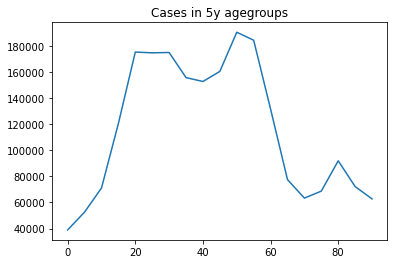

In [13]:
# Sum of all cases per age Group
latest_cases = age_cases5y.sel(publication=datetime.datetime(2021,2,9)).sel(week=range(10,58))

plt.plot(latest_cases.get_index("age"),latest_cases.sum("week") ) 
plt.title("Cases in 5y agegroups")

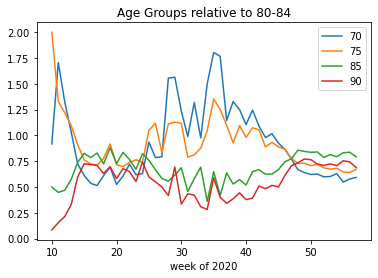

In [14]:
cases_adj = latest_cases.sel(age=[70,75,85,90])
cases_80 = latest_cases.sel(age=80)

rel = cases_adj/cases_80

plt.plot(rel.get_index("week"),rel.transpose("week","age"))
plt.legend(rel.get_index("age").values)
plt.title("Age Groups relative to 80-84")
plt.xlabel("week of 2020")

plt.savefig("plots/AgeGroupsRelativeTo80_byWeeks.pdf")

# Next Step: 1y age resolution
Let's take a look at actual 1y age resolution 0-79 and the group 80+

In [15]:
with open("../Data/Cases/SurvStat_RKI/lks_210210.pickle","br") as f:
    cases = Cases.ParseSurvStatDay_BL(pickle.load(f))

In [16]:
cases1y = cases.sum(["category","BL","sex"])
cases1y.coords

Coordinates:
  * age      (age) int8 0 1 2 3 4 5 6 7 8 9 10 ... 71 72 73 74 75 76 77 78 79 80
  * week     (week) int16 0 1 2 3 4 5 6 7 8 ... 100 101 102 103 104 105 106 107

Text(0.5, 0, 'age')

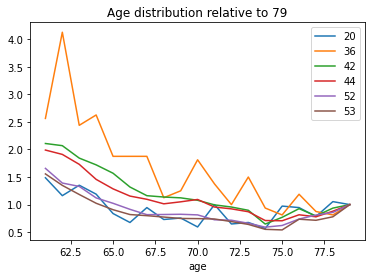

In [17]:
cases1y_ws80 = cases1y.sum("week").sel(age=80)
cases1y_ws = cases1y.sel(week=[20,36,42,44,52,53]).sel(age=range(61,80))
plt.plot(cases1y_ws.get_index("age"),cases1y_ws/cases1y_ws.sel(age=79))
plt.legend(cases1y_ws.get_index("week"))

plt.title("Age distribution relative to 79")
plt.xlabel("age")

Text(0.5, 0, 'age')

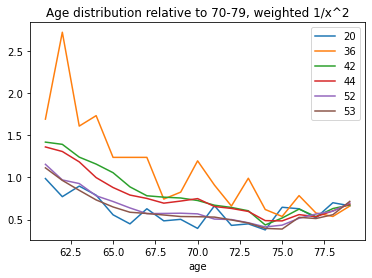

In [18]:
w10 = np.array([1/(x*x) for x in range(1,11)[::-1]],dtype="float64")[:,np.newaxis]
f10 = np.sum( (cases1y_ws.sel(age=range(70,80))*w10) ,axis=0)

plt.plot(cases1y_ws.get_index("age"),cases1y_ws/f10)
plt.legend(cases1y_ws.get_index("week"))

plt.title("Age distribution relative to 70-79, weighted 1/x^2")
plt.xlabel("age")

In [19]:
# Now scale 80+